<a href="https://colab.research.google.com/github/davidgonmar/pid-car-model-classification/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import userdata

# Debe estar configurado en los secretos de Google Colab
kaggle_username = userdata.get("kaggle_username")
kaggle_key = userdata.get("kaggle_key")

if not kaggle_username or not kaggle_key:
    raise ValueError("Kaggle API credentials not found in userdata. Please register them correctly.")


os.environ["KAGGLE_USERNAME"] = kaggle_username
os.environ["KAGGLE_KEY"] = kaggle_key

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

print("✅ Kaggle API authenticated successfully!")

✅ Kaggle API authenticated successfully!


In [2]:
!kaggle datasets download -d rickyyyyyyy/torchvision-stanford-cars -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/rickyyyyyyy/torchvision-stanford-cars
License(s): other
 99% 1.81G/1.83G [00:31<00:00, 102MB/s]
100% 1.83G/1.83G [00:31<00:00, 62.1MB/s]


In [26]:
import torch
import torchvision

In [100]:
import torchvision.transforms as transforms
from torchvision.datasets import StanfordCars
from torch.utils.data import DataLoader, Subset

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_path = "/content"


train_dataset = StanfordCars(root=dataset_path, split='train', transform=transform, download=False)
test_dataset = StanfordCars(root=dataset_path, split='test', transform=transform, download=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print("🚗 Stanford Cars dataset loaded successfully!")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

🚗 Stanford Cars dataset loaded successfully!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [105]:
resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
resnet.fc = torch.nn.LazyLinear(196)
r = resnet.to(device)
print(device)

cuda


In [106]:
subset_size = 5000
indices = torch.randperm(len(test_dataset))[:subset_size]
test_dataloader = DataLoader(Subset(test_dataset, indices), batch_size=64)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [107]:
optim = torch.optim.Adam(resnet.parameters(), lr=0.001)

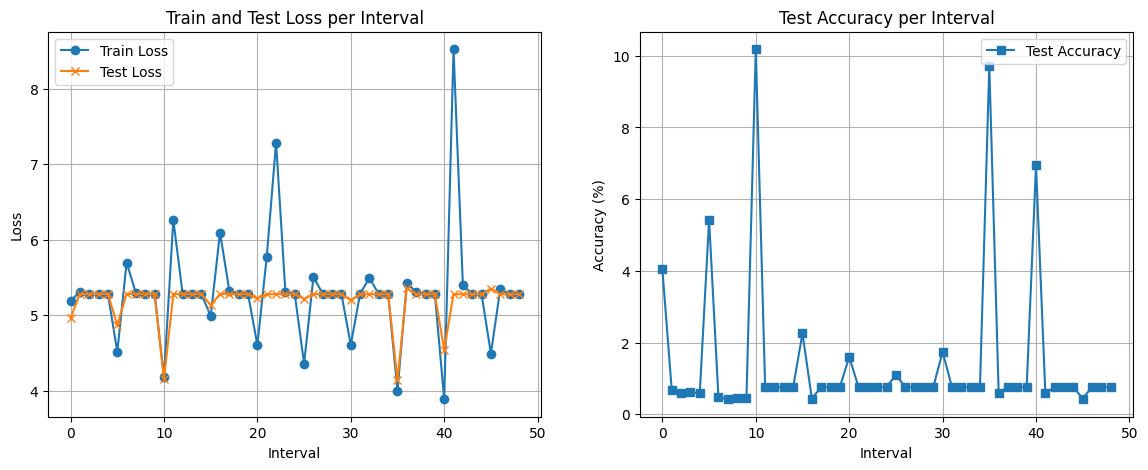

Epoch 10/100:  78%|███████▊  | 100/128 [05:24<07:56, 17.03s/it]

Epoch [10/100], Interval [100], Train Loss: 5.2764, Test Loss: 5.2748, Test Accuracy: 0.76%


Epoch 10/100:  95%|█████████▌| 122/128 [05:46<00:06,  1.06s/it]

In [ ]:
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    correct = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    return avg_loss, accuracy


train_losses, test_losses, test_accuracies = [], [], []

resnet.to(device)

interval = len(train_dataloader) // 5

for ep in range(100):
    resnet.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(tqdm(train_dataloader, desc=f'Epoch {ep+1}/100'), 1):
        data, target = data.to(device), target.to(device)
        optim.zero_grad()
        output = resnet(data)
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optim.step()

        running_loss += loss.item()

        if batch_idx % interval == 0:
            avg_train_loss = running_loss / interval
            train_losses.append(avg_train_loss)
            running_loss = 0.0

            # Evaluate on test set
            test_loss, test_accuracy = evaluate_model(resnet, test_dataloader, device)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)

            # Plot Loss and Accuracy
            clear_output(wait=True)
            plt.figure(figsize=(14,5))

            plt.subplot(1,2,1)
            plt.plot(train_losses, marker='o', label='Train Loss')
            plt.plot(test_losses, marker='x', label='Test Loss')
            plt.xlabel('Interval')
            plt.ylabel('Loss')
            plt.title('Train and Test Loss per Interval')
            plt.legend()
            plt.grid(True)

            plt.subplot(1,2,2)
            plt.plot(test_accuracies, marker='s', label='Test Accuracy')
            plt.xlabel('Interval')
            plt.ylabel('Accuracy (%)')
            plt.title('Test Accuracy per Interval')
            plt.legend()
            plt.grid(True)

            plt.show()

            print(f'Epoch [{ep+1}/100], Interval [{batch_idx}], Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

